In [ ]:
from PIL import Image
import numpy as np
import cv2
import time
import sys
import SimpleITK as sitk
import registration_gui as rgui


%run "common_functions.py"

sys.setrecursionlimit(53000) # override needed for computing midpoints, which uses a recursive function
Image.MAX_IMAGE_PIXELS = 366498276 # override is needed, or else it gives a DecompressionBombError

cy1_shifted_file = "originals/shiftedcycle 1thnksgv.tif"
cy2_shifted_file = "originals/shiftedcycle 2thnksgv.tif"

In [49]:
img_cy1 = Image.open(cy1_shifted_file)
brightfield_cy1 = np.array(img_cy1)
brightfield_cy1 = (brightfield_cy1/256).astype('uint8') # don't need the whole range of values, so this reduces mem size, + improves access speed

img_cy2 = Image.open(cy2_shifted_file)
brightfield_cy2 = np.array(img_cy2)
brightfield_cy2 = (brightfield_cy2/256).astype('uint8') 


KeyboardInterrupt: 

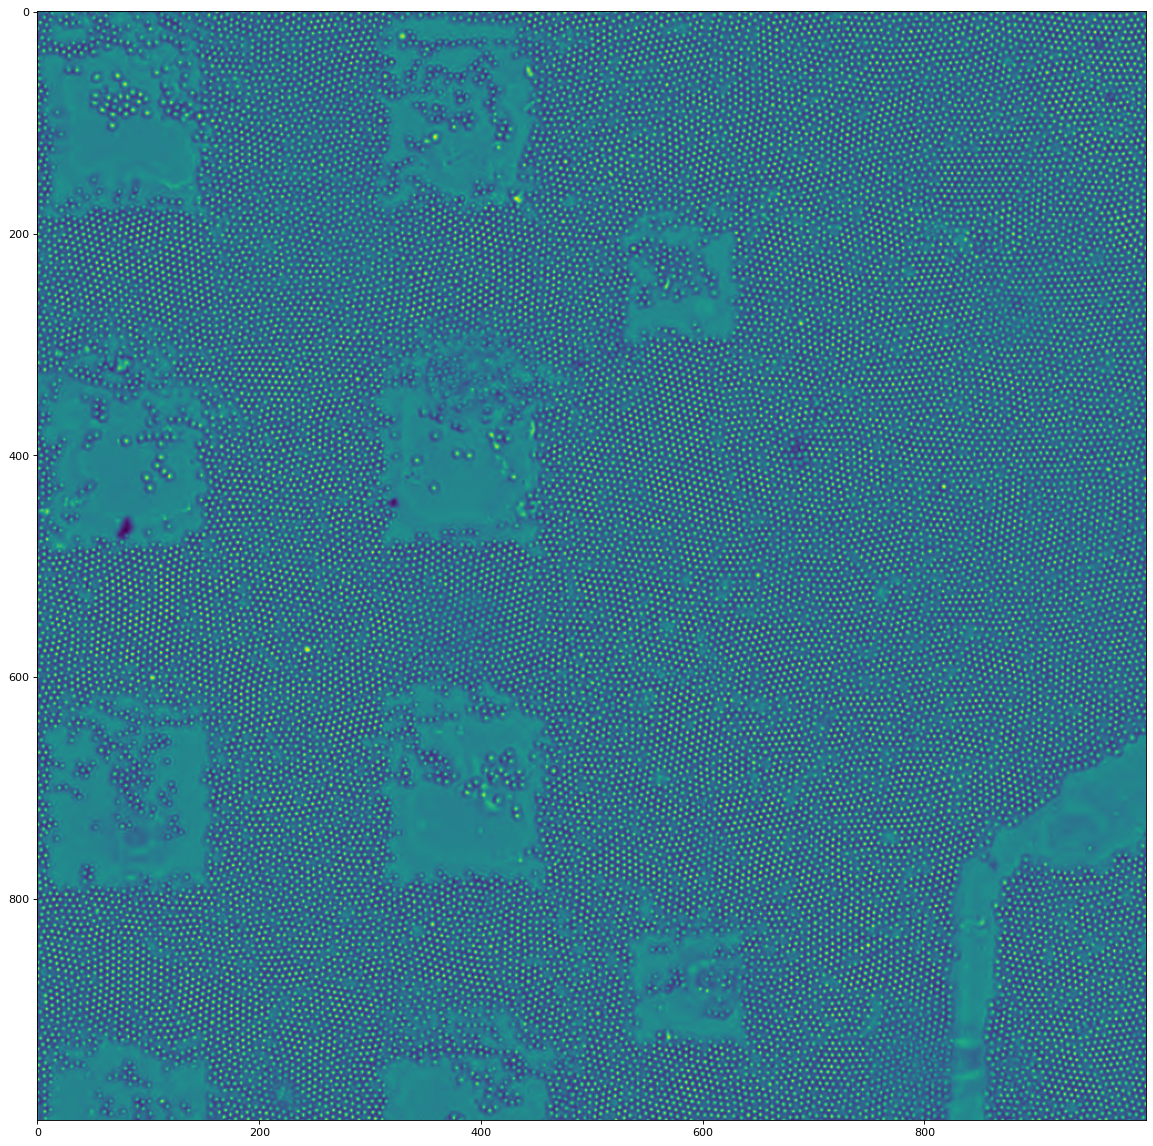

In [65]:
from pylab import *
figure(figsize=(18, 18), dpi=80)

fixed_image = sitk.ReadImage(cy1_shifted_file, sitk.sitkFloat32)[1000:2000, 1000:2000]
moving_image = sitk.ReadImage(cy2_shifted_file, sitk.sitkFloat32)[1000:2000, 1000:2000]
nda = sitk.GetArrayFromImage(moving_image)
imshow(nda)
# plt.savefig('foo.pdf')

In [54]:
# import sys
# import SimpleITK as sitk

# grid_image = sitk.GridSource(
#     outputPixelType=sitk.sitkUInt16,
#     size=(512, 512),
#     sigma=(0.1, 0.1),
#     gridSpacing=(20.0, 20.0),
# )

# # Procedural interface, using the default image viewer (Fiji/ImageJ) or
# # # any viewer specified by the SITK_SHOW_COMMAND environment variable.
# sitk.Show(grid_image, title="grid using Show function", debugOn=True)

# # # # Object oriented interface:
# # image_viewer = sitk.ImageViewer()
# # # image_viewer.SetTitle("grid using ImageViewer class")

# # # # Use the default image viewer.
# # # image_viewer.Execute(grid_image)

# # # Change viewer, and display again.
# # image_viewer.SetApplication(
# #     "/Users/clark/Downloads/ImageJ"
# # )
# # image_viewer.Execute(grid_image)

# # # Change the viewer command, (use ITK-SNAP's -z option to open the image in
# # # zoomed mode)
# # image_viewer.SetCommand(
# #     "/Applications/ITK-SNAP.app/Contents/MacOS/ITK-SNAP -z 2"
# # )
# # image_viewer.Execute(grid_image)

# # # sys.exit(0)

RuntimeError: Exception thrown in SimpleITK Show: /tmp/SimpleITK/Code/IO/src/sitkImageViewer.cxx:620:
sitk::ERROR: No ImageJ/Fiji application found.

In [ ]:
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.Euler2DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)

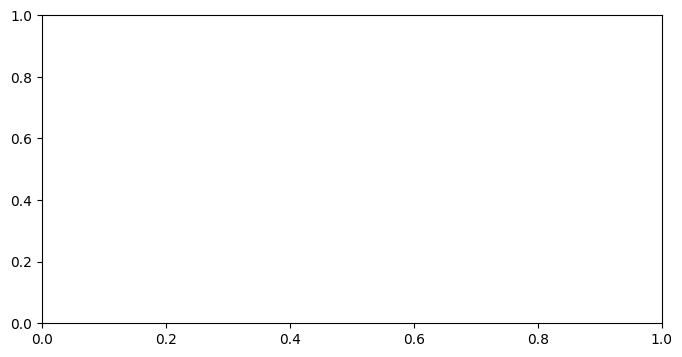

Final metric value: -0.020849798335512187
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 32.


In [79]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(.1)

registration_method.SetInterpolator(sitk.sitkLinear)

registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=1000, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()


registration_method.SetInitialTransform(initial_transform, inPlace=False)

registration_method.AddCommand(sitk.sitkStartEvent, rgui.start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, rgui.end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, rgui.update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: rgui.plot_values(registration_method))

final_transform = registration_method.Execute(fixed_image, moving_image)

# Always check the reason optimization terminated.
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

# print(final_transform)


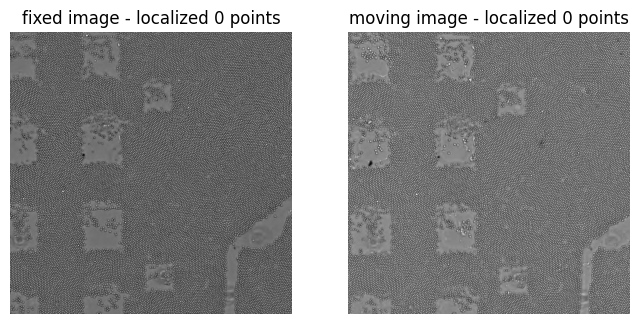

In [68]:
import gui
gui.RegistrationPointDataAquisition(fixed_image, moving_image, figure_size=(8,4), known_transformation=final_transform)

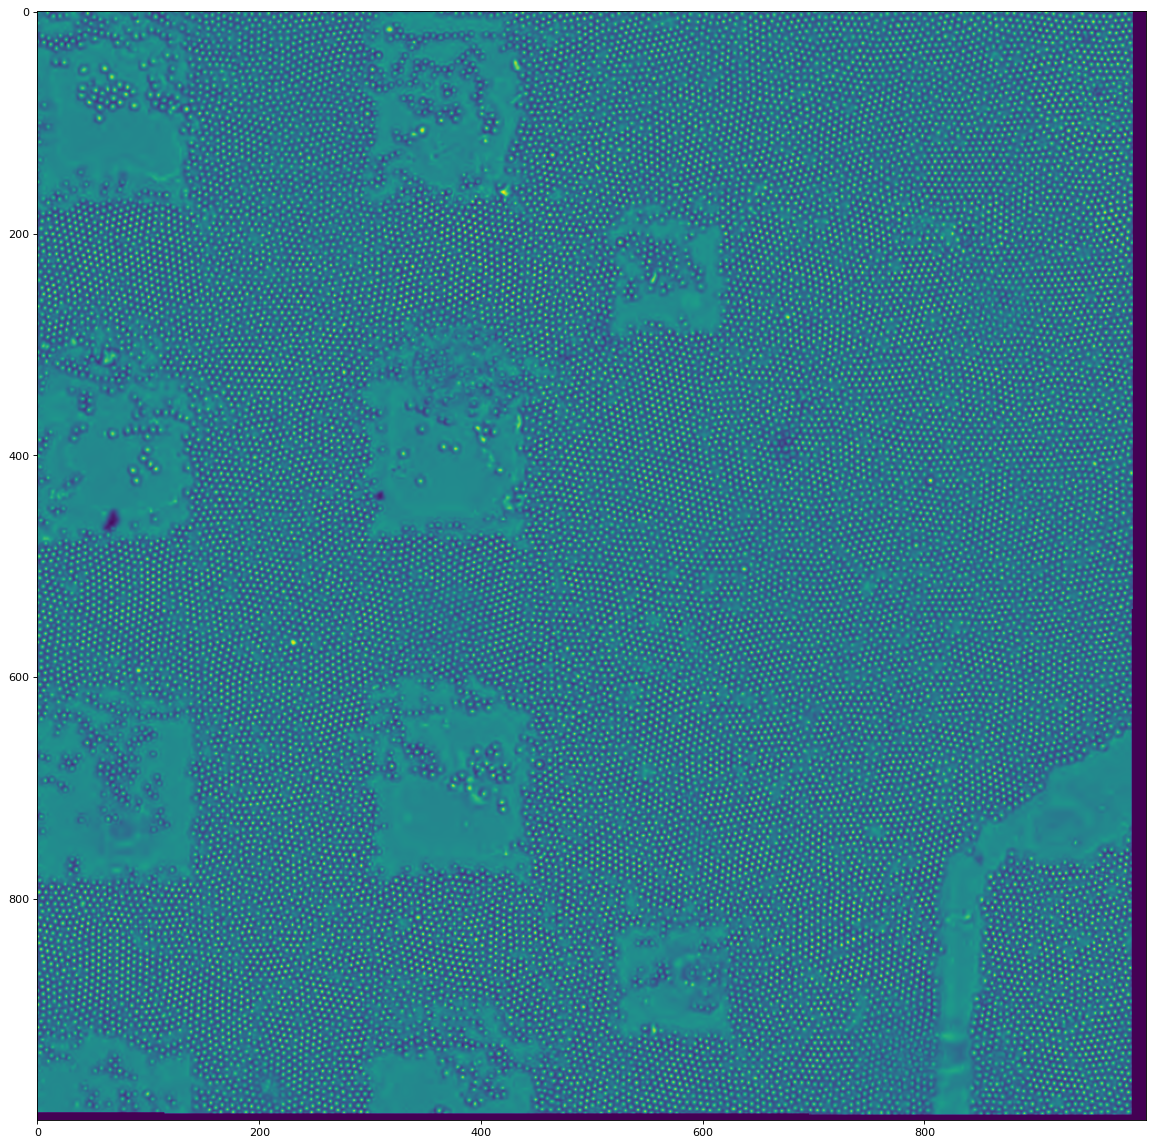

In [80]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
# sitk.WriteImage(moving_image, "sitktest_1.png")
# sitk.WriteTransform(final_transform, os.path.join(OUTPUT_DIR, 'RIRE_training_001_CT_2_mr_T1.tfm'))
figure(figsize=(18, 18), dpi=80)
nda = sitk.GetArrayFromImage(moving_resampled)
imshow(nda)